# Image Stitching:  The final step
Reading: Szeliski 6.1, 9.1

## Homographies

We have successfully made our way through all the steps of image stitching save one.  We have detected keypoints from two images (called image 1 and image 2), generated descriptors, matched them together, and now all we need to do is to determine the way in which we need to move one image (let's call it image 2) such that its pixel intensity information is in *the same coordinate system as image 1*.  

As it turns out, under a very specific assumption about the motion of the camera between images, this transformation is a linear operation called a *homography*.  To see exactly what this operation does, let's reference the following image:

<img src="homography.jpg">

In this image, the blue points are *things* out in the real world, perhaps ones that we've identified as corners and come up with descriptors for.  We'll assume that we've already solved the problem of correspondence: if we see a corner in both images, we have successfully matched it.  These corners reflect light and send out a ray (blue line) which impacts the effective focal plane of the camera.  In the figure, these impacts are denoted by an X in a color corresponding to the image whose focal plane was impacted.  What we need to do is to determine where corners that impacted the second image would have impacted the focal plane of the first image *if that first image had its sensor synthetically extended*, i.e. what are the coordinates of that black question mark?  We can determine this mapping by looking at the points for which we have correspondences.

As it turns out, the transformation from one 2D plane embedded in 3D to another obeys a linear transformation called a *homography*.  A homography is a linear transformation that preserves straight lines (and nothing else).  It occupies the most expressive position on a continuum that ranges from simple rotation (governed by one parameter), to rotation-translations (which preserve scale and relative orientation and position of points), to affine transformations (which preserve scale and parallelity), to homographies (which only preserve straight lines).  We can define it as
$$
\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = \begin{bmatrix} h_{11} & h_{12} & h_{13}\\
                                                               h_{21} & h_{22} & h_{23}\\
                                                               h_{31} & h_{32} & h_{33} \end{bmatrix} 
                                                               \begin{bmatrix} u \\
                                                                               v \\
                                                                               1 \end{bmatrix}
$$                                                               
Note that this makes use of generalized coordinates: after the transformation, we need to divide: $u' = x'/w'$ and $v' = y'/w'$.  What does a homography do?  Here is an example of a random homography on the unit square:


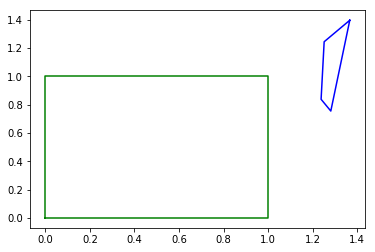

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as skt

X = np.array([[0,0,1],
              [1,0,1],
              [1,1,1],
              [0,1,1],
              [0,0,1]])

H = np.random.rand(3,3)
#H/= H[2,2]

Xprime = (H @ X.T).T
Xprime/=Xprime[:,2][:,np.newaxis]

plt.plot(X[:,0],X[:,1],'g-')
plt.plot(Xprime[:,0],Xprime[:,1],'b-')
plt.show()

How do we solve for this thing given our point correspondences?  We need an equation for the eight unknowns in the matrix $H$.  By doing some algebra, we find that we can generate a linear system of equations for the coefficients of $H$:
$$
A \vec{h} = 0,
$$
where
$$
\vec{h} = \begin{bmatrix} h_{11}, h_{12}, \ldots, h_{32}, h_{33} \end{bmatrix}
$$
and 
$$
A = \begin{bmatrix}  0 & 0 & 0 & -u_1 & -v_1 & -1 & v_1' u_1 & v'_1 v_1& v'_1 \\
                     u_1 & v_1 & 1 &  0   & 0    &  0 & -u'_1 u_1 & -u'_1 v_1 & -u'_1 \\
                     \vdots & \ddots & & & & & & & \vdots \\
                     0 & 0 & 0 & -u_n & -v_n & -1 & v_n' u_n & v'_n v_n& v'_n \\
                     u_n & v_n & 1 &  0   & 0    &  0 & -u'_n u_n & -u'_n v_n & -u'_n \end{bmatrix}
$$                     

Note that for this matrix problem to be well-posed, $n$ (the number of correspondences) must equal 4.  Even still, this system is singular: this is because $h$ is only really defined up to a constant.  Thus, the entries of $h$ are in the nullspace of $A$.  Fortunately, finding this nullspace is easy: take the singular value decomposition of $A$, i.e.
$$
SVD(A) = U \Sigma V^T.
$$
If the singular values (the entries in $\Sigma$) are in descending order (as they usually are), then the nullspace of $A$ is given by the corresponding vector in $V$, or the bottom row in $V^T$.  

As it turns out this SVD-based method for finding the nullspace is also applicable when $n>4$, e.g. we have more correspondences than the requisite 4.  In the case of this overdetermined system, there won'd be a nullspace, but the optimal solution for the homography matrix is still given by the column in $V$ that corresponds to the smallest singular valuem, and there is no change to the routine (except that $A$ has more rows). 

**Your assignment is to generate code that takes a set of point correspondences $\{(u_i,v_i, u'_i,v'_i)\}$ for $i$ in $n$, and solves for the homography matrix between them.  You can directly apply this to the matches that you've found via your stitching code so far, but you will find that this procedure is extremely sensitive to outliers.  To determine if your code is working properly, use the synthetic correspondences generated in the homography demo above to recover the matrix $H$ from $X$ and $X'$.**

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import image_stitching_utils as ims

# Sobel kernal
sobel = np.array([[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]])

# Gaussian Kernal
gauss = ims.gauss_kernal(5,5,2)

# Import Images
img_color1 = plt.imread('trex1.jpg')
img_color2 = plt.imread('trex2.jpg')


im1 = img_color1.mean(axis=2)[1500:2300, 500:-500]
im2 = img_color2.mean(axis=2)[1500:2300, 0:-1000]

# Get Harris Response
H1 = ims.harris_response(im1, sobel, gauss)
H2 = ims.harris_response(im2, sobel, gauss)

# Extract all local max
local_pts1 = ims.extract_pts(H1)
local_pts2 = ims.extract_pts(H2)

# Extract only top N points
max_pts1 = ims.nonmax_suppression(local_pts1, 1000)
max_pts2 = ims.nonmax_suppression(local_pts2, 1000)

# Run Adaptive Supression
corners1 = ims.adaptive_supression(max_pts1, n=100)
corners2 = ims.adaptive_supression(max_pts2, n=100)

# Get Matching Points
mtch, mtch1, mtch2 = ims.image_match_ths(im1, im2, corners1, corners2, bnd=21, r=0.6)

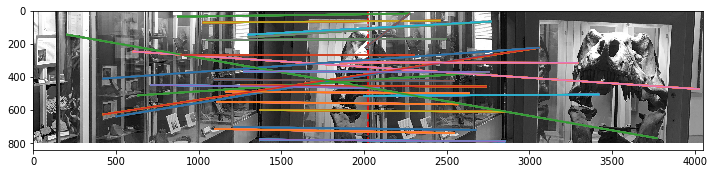

In [128]:
def match_plot(im1, im2, pts_im1, pts_im2, corners1, corners2, w, h):

    m,n = im1.shape

    #Clip two fingures together
    clip_together = np.column_stack((im1, im2))

    #Plots
    fig, ax = plt.subplots(1,1, figsize=(w,h))
    ax.imshow(clip_together, cmap='gray')
   
    #Plot corresponding points
    for i in range(len(pts_im1)):
        ax.plot([pts_im1[:,0], pts_im2[:,0]+n], [pts_im1[:,1], pts_im2[:,1]])

    # Plot the original corners
    #ax.plot(corners1[:,0], corners1[:,1], 'ro')
    #ax.plot(corners2[:,0]+n, corners2[:,1], 'bo')
    
    ax.vlines(n, m, 0, color='r', linestyle='--')
    plt.show()
   
    return

match_plot(im1, im2, mtch1, mtch2, corners1, corners2, 12,8)

In [295]:
# Coordinates of Left image
u = mtch1[:,0]
v = mtch1[:,1]

# Matching Cordinates in right image
u2 = mtch2[:,0]
v2 = mtch2[:,1]

# Append the two together
matches_coords = np.column_stack((mtch1, mtch2))

In [296]:
def homography(p1,p2):

    u,  v  = p1[:,0], p1[:,1]
    up, vp = p2[:,0], p2[:,1]
    
    A = np.zeros((2*len(u), 9))

    for i in range(len(u)):
        A[2*i, :]   = [0, 0, 0, -u[i], -v[i], -1, vp[i]*u[i], vp[i]*v[i], vp[i]]
        A[2*i+1, :] = [u[i], v[i], 1, 0, 0, 0, -up[i]*u[i], -up[i]*v[i], -up[i]]

    U,Sigma,Vt = np.linalg.svd(A)

    homog = Vt[-1,:].reshape(3,3)

    return homog

In [297]:
# Test the homography function
X = np.array([[0,0,1],
              [1,0,1],
              [1,1,1],
              [0,1,1],
              [0,0,1]])

H = np.random.rand(3,3)
print (H)

Xprime = (H @ X.T).T
Xprime/=Xprime[:,2][:,np.newaxis]

H_test = homography(X, Xprime)

print ('\n')
print (H_test)

print ('\n')
print (H/H_test)

[[0.17940401 0.28039382 0.99538943]
 [0.53753049 0.59259694 0.7020713 ]
 [0.89542924 0.30064669 0.34260544]]


[[-0.09960464 -0.15567393 -0.55263764]
 [-0.29843554 -0.32900829 -0.38978818]
 [-0.49714    -0.16691827 -0.19021366]]


[[-1.80116111 -1.80116111 -1.80116111]
 [-1.80116111 -1.80116111 -1.80116111]
 [-1.80116111 -1.80116111 -1.80116111]]


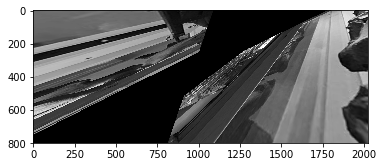

In [298]:
# Homography Based on Matching points from two images
H = homography(matches_coords[:,[0,1]], matches_coords[:,[2,3]])

# Create a projective transform based on the homography matrix $H$
proj_trans = skt.ProjectiveTransform(H)

# Warp the image into image 1's coordinate system
image_2_transformed = skt.warp(im2, proj_trans)

plt.imshow(image_2_transformed, cmap='gray')
plt.show()

## RANSAC
Now you have the methods necessary to produce homographies between images, right?  Well, almost.  As it turns out, the computation of the homography is *highly* sensitive to error, e.g. faulty matches.  The following is the result of my code after running the ratio test:
<img src="filtered_matches.png">
Obviously, most of the matches are correct.  However, a few are incorrect, and those incorrect ones are going to have an outsize influence on the computed homography.  For example, here's the stitch I get from using all the points in the above image:
<img src="bad_homography.png">
We need to come up with some way of eliminating bad matches.  Another way of saying this is that we need to remove matches that are *outliers*: a data point that we believe was generated by a different process than the one we're trying to model.  Because a homography does in fact capture the change in an image under the assumption of pure rotation, a bad match created by our matching routine is exactly an outlier.  

There are quite a few algorithms proposed over the years for identifying and eliminating outliers, but by far the most popular (particularly in computer vision) is called RANdom SAmple Consensus, or RANSAC for short.  As the name implies, it is a randomized algorithm, and does not guarantee the optimal solution.  However, it works very well in practice and is fast.  The idea is as follows: First, take a random subset of data (i.e. a random subset of the matches) of size $n$.  Compute a homography based on these $n$ randomly selected matches, which we'll call $H_{maybe}$.  Now, for the remaining points not used to fit the model, apply $H_{maybe}$ to the point locations in image 1 to predict their position in image 2.
$$
\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = H_{maybe} \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
$$
$$ 
u' = x'/w'
$$
$$
v' = y'/w'
$$



For each point, compute the distance between this predicted point and the data value: 
$$
R_i = \sqrt{(u_i' - u_i)^2 + (v_i' - v_i)^2}.
$$
If $R_i<r$, where $r$ is an outlier threshold (often 3-5 pixels), then the point is considered an inlier.  Otherwise it is an outlier.  Combine these inliers with the points used to compute the initial homography.  If the number of inliers is greater than any previous iteration, recompute $H$.  The best $H$ will be that for which the number of inliers is maximized.  This is more easily understood in pseudocode:

In [299]:
def RANSAC(number_of_iterations,matches,n,r,d):
    H_best = np.array([[1,0,0],[0,1,0],[0,0,1]])
    list_of_inliers = []
    inlier_itr_prev = 0
    
    
    # matches = [u1, v1, u2, v2]
    for i in range(number_of_iterations):
        # 1. Select a random sample of length n from the matches
        np.random.shuffle(matches)
        rand_set = matches[0:n,:]
        test_set = matches[n:,:]
        
        # 2. Compute a homography based on these points using the methods given above
        uv = rand_set[:,[0,1]]
        uv_prime = rand_set[:,[2,3]]
        H_test = homography(uv, uv_prime)
        
        # 3. Apply this homography to the remaining points that were not randomly selected
        uv_test = test_set[:, [2,3]]
        ones = np.ones((uv_test.shape[0],1))
        uv_test = np.column_stack((uv_test, ones)) 
        
        uv_prime_test = (H_test @ uv_test.T).T     # Calculate homography and apply to test points in image 1
        uv_prime_test /= uv_prime_test[:,2][:,np.newaxis] # to get points in image 2 that can
        uv_prime_test = uv_prime_test[:,[0,1]] / uv_prime_test[:,2][:,np.newaxis] # be compared to image 2 known test points
        
        # 4. Compute the residual between observed and predicted feature locations
        uv_prime_kwn = test_set[:, [0,1]]
        diff = (uv_prime_kwn[:,0] - uv_prime_test[:,0])**2 + (uv_prime_kwn[:,1] - uv_prime_test[:,1])**2
        R = np.sqrt(diff)  # This is an array of length test_set[0]
        
        # 5. Flag predictions that lie within a predefined distance r from observations as inliers
        inliers_itr = 0
        temp_inliers = [] #indices from test set to that are in
        for i in range(len(R)):
            if R[i] < r:
                temp_inliers.append(i)
                inliers_itr += 1
            else:
                pass
    
        print (inliers_itr)
        # 6. If number of inliers is greater than the previous best
        #    and greater than a minimum number of inliers d, 
        #    7. update H_best
        #    8. update list_of_inliers
        if inliers_itr > inlier_itr_prev and inliers_itr > d:
            uv_prime_keep = uv_prime_test[[temp_inliers], :]
            list_of_inliers = uv_prime_keep 
            H_best = H_test
            inlier_itr_prev = inliers_itr
    
    return H_best, list_of_inliers


RN_H_best, inliers = RANSAC(200, matches_coords, n=20, r=100, d=4)



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Note that the wikipedia page for RANSAC also has an excellent pseudocode description: https://en.wikipedia.org/wiki/Random_sample_consensus

**Implement RANSAC for the problem of matching keypoints, and apply it to your images.  Write a function which returns a robust estimate of the homography matrix between the two images**

## Warping
With a homography matrix in hand, we can warp image 2 into the coordinate system of image 1.  A do-it-yourself implementation of this process takes a bit of doing.  In particular, it requires that we create an interpolant of image 2 in its original coordinate system, then for each point in image_1's coordinate system, we apply the inverse of the homography and sample from that location.  While not terribly difficult to implement in practice, we will instead simply use a built-in function from scikit-image:

In [292]:
import skimage.transform as skt
H_best = RN_H_best # CHANGE ME!
print (H_best)

# Create a projective transform based on the homography matrix $H$
proj_trans = skt.ProjectiveTransform(H_best)

# Warp the image into image 1's coordinate system
image_2_transformed = skt.warp(im2, proj_trans)

# Get first key point in im2 in terms of im1
first_im2 = matches_coords[0,[2,3]]
first_im2 = np.expand_dims(np.append(first_im2, 1), axis=0)

first_im2_im1 = (H_best @ first_im2.T).T # Calculate homography and apply to test points in image 1
first_im2_im1 /= first_im2_im1[:,2][:,np.newaxis] # to get points in image 2 that can
first_im2_im1 = first_im2_im1[:,[0,1]] / first_im2_im1[:,2][:,np.newaxis] # be compared to image 2 known test points
        

[[1 0 0]
 [0 1 0]
 [0 0 1]]


TypeError: No loop matching the specified signature and casting
was found for ufunc true_divide

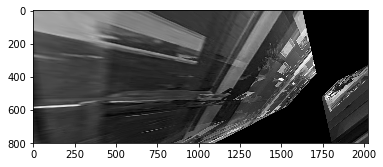

In [283]:
plt.imshow(image_2_transformed, cmap='gray')
plt.show()

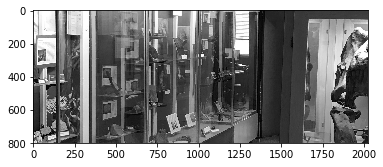

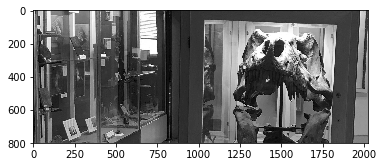

In [284]:
plt.imshow(im1, cmap='gray')
plt.show()
plt.imshow(im2, cmap='gray')
plt.show()